In [ ]:
pip install -r requirements.txt

In [1]:
import pandas as pd
import petl as etl

In [ ]:
# Load file label

label1 = etl.fromtext('rumor_detection_acl2017/twitter15/label.txt')
label1 = label1.capture('lines', '(.*):(.*)$', ['label', 'src_tweet_id'])
label1

In [ ]:
# Load file label

label2 = etl.fromtext('rumor_detection_acl2017/twitter16/label.txt')
label2 = label2.capture('lines', '(.*):(.*)$', ['label', 'src_tweet_id'])
label2

In [ ]:
# load file source_tweets

source_tweet1 = etl.fromtext('rumor_detection_acl2017/twitter15/source_tweets.txt')
source_tweet1 = source_tweet1.capture('lines', '(.*)\t(.*)$', ['src_tweet_id', 'content'])
source_tweet1

In [ ]:
# load file source_tweets

source_tweet2 = etl.fromtext('rumor_detection_acl2017/twitter16/source_tweets.txt')
source_tweet2 = source_tweet2.capture('lines', '(.*)\t(.*)$', ['src_tweet_id', 'content'])
source_tweet2

In [ ]:
# join table berdasarkan source tweet id
# rename header sesuai dengan codingan asal

tweet_text1 = etl.join(label1, source_tweet1, key='src_tweet_id')
tweet_text1 = etl.cut(tweet_text1, 'label', 'content')
tweet_text1 = etl.setheader(tweet_text1, ['category', 'text'])
tweet_text1

In [ ]:
tweet_text2 = etl.join(label2, source_tweet2, key='src_tweet_id')
tweet_text2 = etl.cut(tweet_text2, 'label', 'content')
tweet_text2 = etl.setheader(tweet_text2, ['category', 'text'])
tweet_text2

In [ ]:
# untuk mengetahui labelnya apa saja

tweet_text1.distinct('category')

In [ ]:
tweet_text2.distinct('category')

In [ ]:
print(len(tweet_text1))
print(len(tweet_text2))
len(tweet_text1)+len(tweet_text2)

In [ ]:
# menyimpan ke file csv

etl.tocsv(tweet_text1, 'tweet-text-1.csv')
etl.appendcsv(tweet_text2, 'tweet-text-1.csv')

In [ ]:
tweet_text3 = etl.select(tweet_text1, "{category} == 'true' or {category} == 'false'")
tweet_text3 = etl.convert(tweet_text3, 'category', 'replace', 'true', 'ya')
tweet_text3 = etl.convert(tweet_text3, 'category', 'replace', 'false', 'tidak')

tweet_text4 = etl.select(tweet_text2, "{category} == 'true' or {category} == 'false'")
tweet_text4 = etl.convert(tweet_text4, 'category', 'replace', 'true', 'ya')
tweet_text4 = etl.convert(tweet_text4, 'category', 'replace', 'false', 'tidak')

etl.tocsv(tweet_text3, 'tweet-text-binary.csv')
etl.appendcsv(tweet_text4, 'tweet-text-binary.csv')

In [3]:
# datapath = 'bbc-text.csv'
datapath = 'tweet-text-1.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,false,deep-fried left wings demo-crab cakes barack-a...
1,false,42 million dead in bloodiest black friday week...
2,false,42 million dead in bloodiest black friday week...
3,true,#prayforchristopher 5k run .. well we are walk...
4,false,a photo of black nurses saving the life of a k...


<AxesSubplot:xlabel='category'>

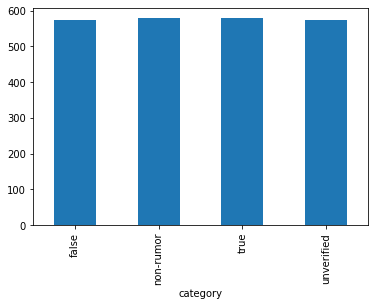

In [4]:
df.groupby(['category']).size().plot.bar()

In [5]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# labels = {'business':0,
#           'entertainment':1,
#           'sport':2,
#           'tech':3,
#           'politics':4
#           }
labels = {'false':0,
          'non-rumor':1,
          'true':2,
          'unverified':3,
          }
# labels = {'tidak':0,
#           'ya':1,
#           }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [6]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1846 231 231


In [7]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
#         self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [8]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.36it/s]


Epochs: 1 | Train Loss:  0.701                 | Train Accuracy:  0.262                 | Val Loss:  0.706                 | Val Accuracy:  0.255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.28it/s]


Epochs: 2 | Train Loss:  0.684                 | Train Accuracy:  0.308                 | Val Loss:  0.684                 | Val Accuracy:  0.325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.28it/s]


Epochs: 3 | Train Loss:  0.659                 | Train Accuracy:  0.368                 | Val Loss:  0.659                 | Val Accuracy:  0.390


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.28it/s]


Epochs: 4 | Train Loss:  0.619                 | Train Accuracy:  0.449                 | Val Loss:  0.633                 | Val Accuracy:  0.424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.26it/s]


Epochs: 5 | Train Loss:  0.556                 | Train Accuracy:  0.549                 | Val Loss:  0.581                 | Val Accuracy:  0.515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.15it/s]


Epochs: 6 | Train Loss:  0.471                 | Train Accuracy:  0.653                 | Val Loss:  0.553                 | Val Accuracy:  0.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.17it/s]


Epochs: 7 | Train Loss:  0.386                 | Train Accuracy:  0.753                 | Val Loss:  0.520                 | Val Accuracy:  0.554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.17it/s]


Epochs: 8 | Train Loss:  0.323                 | Train Accuracy:  0.813                 | Val Loss:  0.497                 | Val Accuracy:  0.606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:24<00:00, 10.91it/s]


Epochs: 9 | Train Loss:  0.251                 | Train Accuracy:  0.879                 | Val Loss:  0.446                 | Val Accuracy:  0.649


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:23<00:00, 11.10it/s]


Epochs: 10 | Train Loss:  0.196                 | Train Accuracy:  0.927                 | Val Loss:  0.428                 | Val Accuracy:  0.680


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.24it/s]


Epochs: 11 | Train Loss:  0.142                 | Train Accuracy:  0.958                 | Val Loss:  0.416                 | Val Accuracy:  0.697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.21it/s]


Epochs: 12 | Train Loss:  0.104                 | Train Accuracy:  0.975                 | Val Loss:  0.405                 | Val Accuracy:  0.701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.22it/s]


Epochs: 13 | Train Loss:  0.074                 | Train Accuracy:  0.985                 | Val Loss:  0.395                 | Val Accuracy:  0.719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.25it/s]


Epochs: 14 | Train Loss:  0.053                 | Train Accuracy:  0.989                 | Val Loss:  0.417                 | Val Accuracy:  0.706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.24it/s]


Epochs: 15 | Train Loss:  0.039                 | Train Accuracy:  0.990                 | Val Loss:  0.415                 | Val Accuracy:  0.714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.31it/s]


Epochs: 16 | Train Loss:  0.029                 | Train Accuracy:  0.993                 | Val Loss:  0.413                 | Val Accuracy:  0.719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.27it/s]


Epochs: 17 | Train Loss:  0.020                 | Train Accuracy:  0.996                 | Val Loss:  0.424                 | Val Accuracy:  0.723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.32it/s]


Epochs: 18 | Train Loss:  0.016                 | Train Accuracy:  0.996                 | Val Loss:  0.420                 | Val Accuracy:  0.723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:22<00:00, 11.25it/s]


Epochs: 19 | Train Loss:  0.014                 | Train Accuracy:  0.996                 | Val Loss:  0.441                 | Val Accuracy:  0.736


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [01:21<00:00, 11.28it/s]


Epochs: 20 | Train Loss:  0.012                 | Train Accuracy:  0.997                 | Val Loss:  0.431                 | Val Accuracy:  0.740


In [9]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    result = []
    label_result = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)  
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              result.append(output.cpu().numpy()[0])
#               label_result.append(output.argmax(dim=1).cpu().numpy()[0])
              label_result.append(test_label.cpu().numpy()[0])

              acc = (output.argmax(dim=1) == test_label).sum().item()
              
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return [np.array(result, dtype=np.float32), np.array(label_result, dtype=np.int8)]

In [10]:
evaluate(model, df_test)

Test Accuracy:  0.779


[array([[3.70641088e+00, 1.75851107e+00, 4.77828085e-01, 1.60516167e+00],
        [2.25525618e-01, 4.63642645e+00, 0.00000000e+00, 1.21908009e+00],
        [3.72152996e+00, 3.42932200e+00, 3.38788889e-03, 1.33368149e-01],
        [1.74235538e-01, 0.00000000e+00, 6.01079702e+00, 0.00000000e+00],
        [0.00000000e+00, 6.15455008e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.65915203e+00],
        [0.00000000e+00, 3.79563510e-01, 6.86919019e-02, 6.09116936e+00],
        [8.90002131e-01, 0.00000000e+00, 4.84402657e+00, 3.16611004e+00],
        [5.91105938e+00, 3.79413962e-01, 0.00000000e+00, 0.00000000e+00],
        [6.44234657e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.61482483e-01, 0.00000000e+00, 0.00000000e+00, 5.36335039e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.87050295e+00],
        [0.00000000e+00, 0.00000000e+00, 2.72233486e+00, 4.10875845e+00],
        [3.50318241e+00, 1.80393994e+0

In [11]:
vectorized_data, label_vectorized_data = evaluate(model, df)

Test Accuracy:  0.947


In [12]:
vectorized_data

array([[5.657049  , 0.        , 0.8004064 , 0.        ],
       [6.028482  , 1.3202146 , 0.7355795 , 0.        ],
       [5.5220814 , 1.0562409 , 0.09823424, 0.        ],
       ...,
       [0.        , 0.        , 0.13821816, 5.4364233 ],
       [0.6659887 , 0.        , 0.06329691, 7.3466935 ],
       [0.6251284 , 0.        , 0.        , 6.607492  ]], dtype=float32)

In [13]:
label_vectorized_data

array([0, 0, 0, ..., 3, 3, 3], dtype=int8)

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_data, label_vectorized_data,
                                                    stratify=label_vectorized_data, random_state=1)
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(4,), max_iter=1000).fit(X_train, y_train)

In [15]:
clf.predict_proba(X_test)

array([[6.9064379e-02, 8.4446305e-01, 2.3704767e-02, 6.2767774e-02],
       [6.0158700e-04, 6.6118658e-02, 1.5919335e-03, 9.3168783e-01],
       [8.9902133e-02, 8.5139203e-01, 2.4329893e-02, 3.4375988e-02],
       ...,
       [6.0158700e-04, 6.6118658e-02, 1.5919335e-03, 9.3168783e-01],
       [6.0766976e-04, 6.6228785e-02, 1.6218402e-03, 9.3154174e-01],
       [8.0952287e-01, 1.8366385e-01, 6.8123299e-03, 9.9915349e-07]],
      dtype=float32)

In [16]:
clf.predict(X_test)

array([1, 3, 1, 1, 0, 2, 1, 3, 1, 2, 0, 0, 3, 0, 1, 2, 3, 1, 3, 0, 2, 1,
       3, 2, 3, 0, 2, 2, 2, 0, 3, 3, 2, 3, 0, 2, 2, 1, 3, 0, 3, 2, 2, 0,
       1, 3, 2, 2, 2, 3, 0, 2, 3, 0, 3, 2, 0, 1, 2, 1, 0, 2, 3, 1, 2, 3,
       0, 3, 2, 3, 1, 3, 0, 1, 2, 2, 0, 2, 2, 1, 1, 1, 3, 0, 2, 1, 0, 0,
       1, 1, 3, 1, 2, 3, 1, 1, 1, 0, 1, 3, 0, 1, 2, 2, 2, 1, 1, 1, 0, 3,
       1, 0, 3, 0, 1, 2, 0, 3, 3, 2, 3, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 1,
       3, 0, 0, 1, 2, 1, 0, 3, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 2, 1, 3, 1,
       2, 3, 1, 2, 2, 1, 3, 1, 2, 3, 0, 3, 3, 2, 1, 2, 0, 0, 3, 1, 2, 2,
       2, 0, 2, 2, 3, 0, 0, 1, 0, 3, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 1, 3,
       3, 0, 0, 3, 3, 1, 0, 3, 1, 2, 2, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 3,
       0, 2, 3, 1, 2, 0, 0, 0, 0, 3, 2, 3, 3, 0, 3, 2, 0, 2, 1, 3, 3, 3,
       1, 0, 0, 3, 1, 1, 2, 1, 0, 3, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 3, 0,
       2, 3, 0, 2, 0, 1, 1, 2, 2, 3, 1, 3, 1, 1, 3, 1, 0, 1, 3, 2, 3, 1,
       1, 3, 2, 2, 2, 1, 0, 3, 1, 3, 2, 1, 0, 3, 2,

In [17]:
clf.score(X_test, y_test)

0.9393414211438474